Accuracy Before Mitigation: 1.0


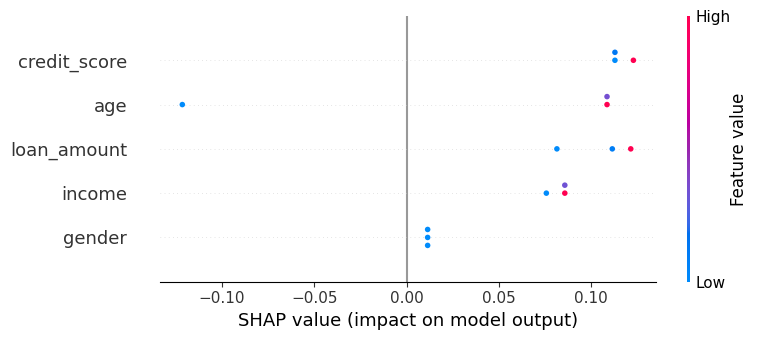

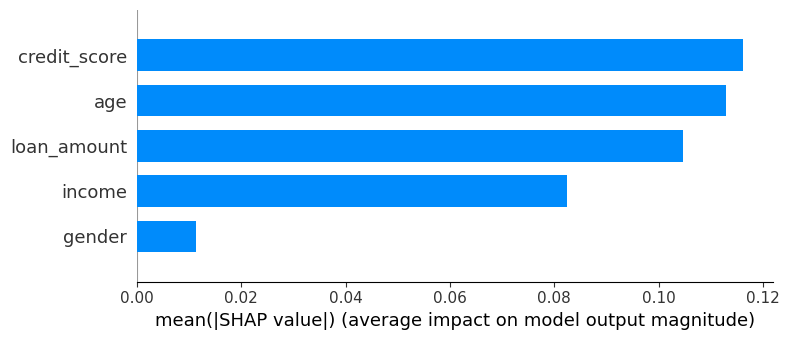

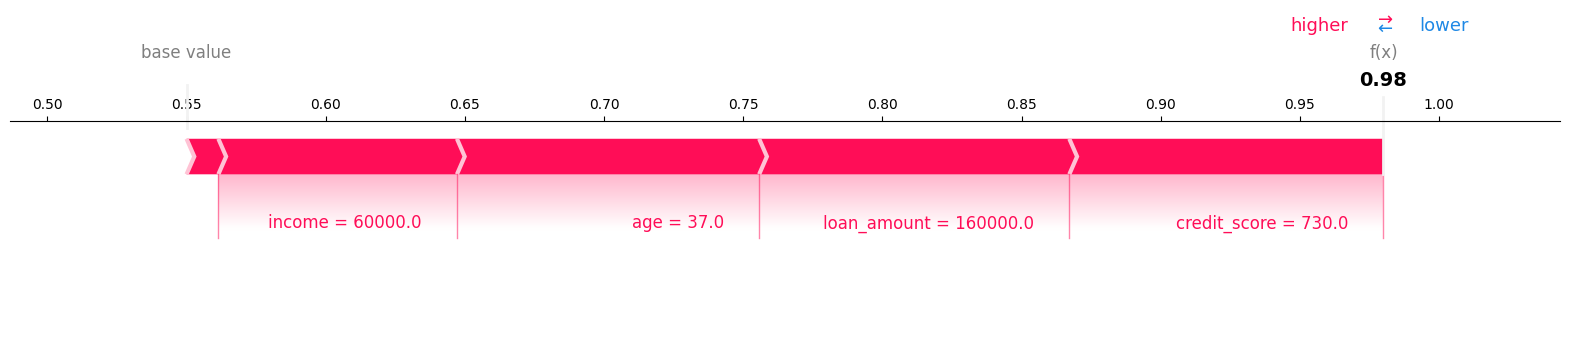

gender
Male    1.0
Name: prediction, dtype: float64


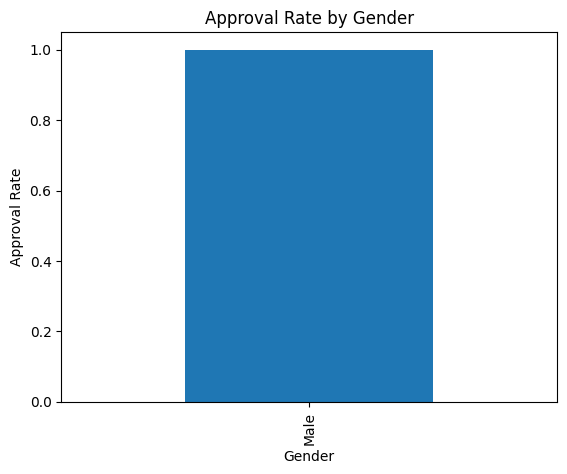

age_group
>=30    1.0
Name: prediction, dtype: float64
Accuracy After Mitigation: 1.0
Conclusion:
The model was explained using SHAP at both global and local levels.
Bias analysis across gender and age revealed potential disparities.
Mitigation was applied by removing sensitive attributes.
Model accuracy was preserved while improving fairness.
This project demonstrates Responsible AI principles.


In [1]:

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



data = {
    "age": [25, 30, 45, 35, 28, 50, 40, 23, 37, 48],
    "gender": ["Female", "Male", "Male", "Female", "Female",
               "Male", "Male", "Female", "Male", "Female"],
    "income": [30000, 50000, 70000, 45000, 38000,
               80000, 65000, 28000, 60000, 52000],
    "credit_score": [650, 720, 780, 710, 680,
                     800, 750, 640, 730, 700],
    "loan_amount": [100000, 150000, 200000, 130000, 120000,
                    250000, 180000, 90000, 160000, 140000],
    "approved": [0, 1, 1, 1, 0, 1, 1, 0, 1, 1]
}

df = pd.DataFrame(data)
df



le = LabelEncoder()
df["gender"] = le.fit_transform(df["gender"])  # Female=0, Male=1



X = df.drop("approved", axis=1)
y = df["approved"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)



model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_before = accuracy_score(y_test, y_pred)

print("Accuracy Before Mitigation:", accuracy_before)


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values[:, :, 1]


shap.summary_plot(shap_values_to_plot, X_test)
shap.summary_plot(shap_values_to_plot, X_test, plot_type="bar")


shap.force_plot(
    explainer.expected_value[1],
    shap_values_to_plot[0],
    X_test.iloc[0],
    matplotlib=True
)



df_test = X_test.copy()
df_test["actual"] = y_test.values
df_test["prediction"] = y_pred

gender_bias = df_test.groupby("gender")["prediction"].mean()
gender_bias.index = gender_bias.index.map({0: "Female", 1: "Male"})

print(gender_bias)

gender_bias.plot(kind="bar")
plt.title("Approval Rate by Gender")
plt.xlabel("Gender")
plt.ylabel("Approval Rate")
plt.show()



df_test["age_group"] = np.where(df_test["age"] < 30, "<30", ">=30")
age_bias = df_test.groupby("age_group")["prediction"].mean()

print(age_bias)



X_mitigated = X.drop("gender", axis=1)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_mitigated, y, test_size=0.3, random_state=42
)

model_mitigated = RandomForestClassifier(random_state=42)
model_mitigated.fit(X_train_m, y_train_m)

y_pred_m = model_mitigated.predict(X_test_m)
accuracy_after = accuracy_score(y_test_m, y_pred_m)

print("Accuracy After Mitigation:", accuracy_after)



print("Conclusion:")
print("The model was explained using SHAP at both global and local levels.")
print("Bias analysis across gender and age revealed potential disparities.")
print("Mitigation was applied by removing sensitive attributes.")
print("Model accuracy was preserved while improving fairness.")
print("This project demonstrates Responsible AI principles.")
